In [61]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import BandIndices

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
   
#         #Tuross Head
# 'y': (-36.01, -36.092),
# 'x': (150.047, 150.186), 
    
    #Myall lakes little
# 'y': (-32.371, -32.421),
# 'x': (152.445, 152.531),   
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
#     #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#ACT LArge
# 'y': (-35.216, -35.414),
# 'x': (149.040, 149.309),      
    
    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
# #gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
  
    
#Kakadu subset
# 'y': (-12.640, -12.822),
# 'x': (132.545, 132.765),
  
#Adelaide River
# 'y': (-12.136, -12.415),
# 'x': (131.163, 131.423),

#Shoal Bay
'y': (-12.276, -12.420),
'x': (130.971, 131.125),
    
    #NT
# 'y': (-13.105, -13.255),
# 'x': (130.440, 130.709),
    
    
'time': ('2016-01-01', '2016-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [63]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8.isel(time=0)

<xarray.Dataset>
Dimensions:          (x: 688, y: 632)
Coordinates:
    time             datetime64[ns] 2016-01-06T01:22:52
  * y                (y) float64 -1.295e+06 -1.295e+06 ... -1.31e+06 -1.31e+06
  * x                (x) float64 -1.14e+05 -1.14e+05 ... -9.689e+04 -9.686e+04
Data variables:
    coastal_aerosol  (y, x) int16 1073 1089 1082 1072 1072 ... 523 537 520 533
    blue             (y, x) int16 1100 1112 1116 1106 1106 ... 419 427 420 428
    green            (y, x) int16 1237 1265 1262 1248 1248 ... 595 606 601 620
    red              (y, x) int16 680 706 707 688 688 ... 462 463 484 474 482
    nir              (y, x) int16 391 410 411 401 401 ... 2879 2813 2998 3082
    swir1            (y, x) int16 318 333 341 320 320 ... 1448 1566 1521 1612
    swir2            (y, x) int16 264 267 280 266 266 ... 734 697 781 751 778
Attributes:
    crs:      EPSG: 3577

In [64]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

23

In [65]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.copy(deep=True).where(~want_to_mask, np.NaN)

In [66]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 23, x: 688, y: 632)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-06T01:22:52 ... 2016-12-23T01:23:01.500000
  * y             (y) float64 -1.295e+06 -1.295e+06 ... -1.31e+06 -1.31e+06
  * x             (x) float64 -1.14e+05 -1.14e+05 ... -9.689e+04 -9.686e+04
Data variables:
    pixelquality  (time, y, x) int16 15871 15871 15871 ... 16383 16383 16383
Attributes:
    crs:      EPSG: 3577

In [67]:
# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 688, y: 632)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01
  * y            (y) float64 -1.295e+06 -1.295e+06 ... -1.31e+06 -1.31e+06
  * x            (x) float64 -1.14e+05 -1.14e+05 ... -9.689e+04 -9.686e+04
Data variables:
    count_wet    (time, y, x) int16 23 23 23 23 23 23 23 23 ... 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 23 23 23 23 23 23 23 ... 17 17 17 18 18 18
    frequency    (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577

In [68]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 23, y: 632, x: 688)>
array([[[ True,  True, ..., False,  True],
        [ True,  True, ..., False,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False,  True, ..., False, False],
        [False,  True, ..., False, False],
        ...,
        [ True, False, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-06T01:22:52 ... 2016-12-23T01:23:01.500000
  * y        (y) float64 -1.295e+06 -1.295e+06 ... -1.31e+06 -1.31e+06
  * x   

In [69]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

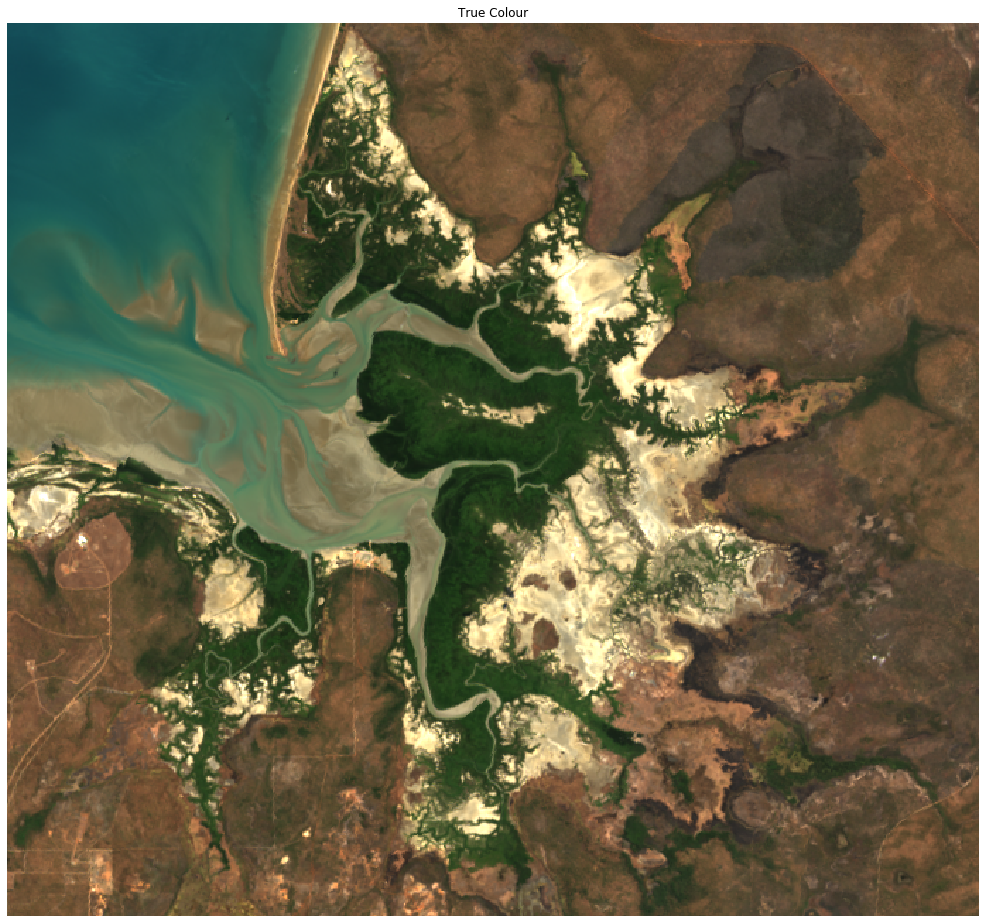

In [70]:
data_lst8_once = Masked_lst8_data.isel(time=14)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [71]:
#Do tassled Cap transformation
TCI = BandIndices.tasseled_cap(Masked_lst8_data, tc_bands=['wetness'], drop=True)

tcw = TCI['wetness']




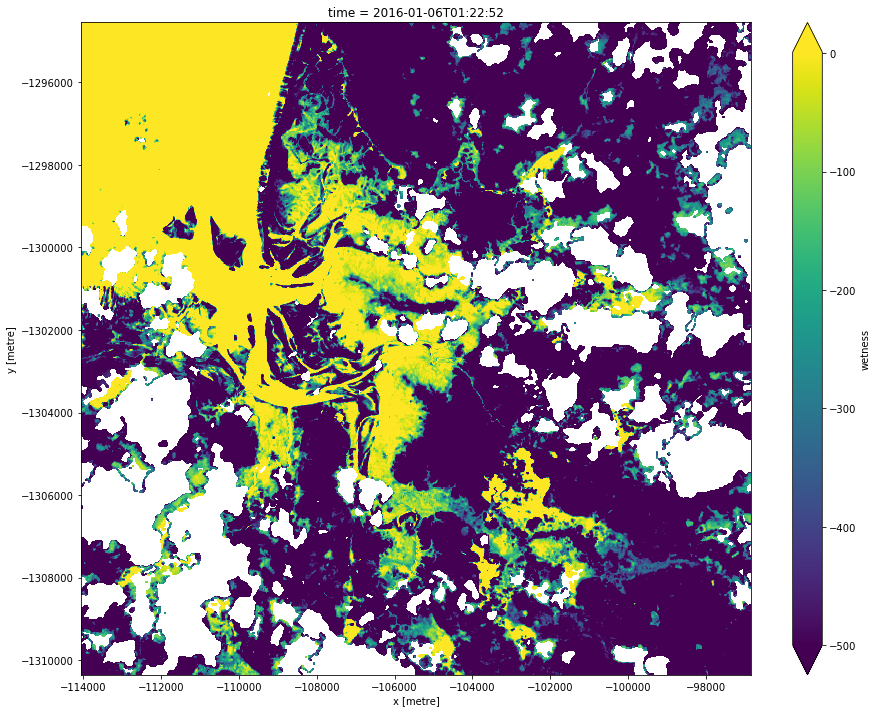

In [86]:
tcw.isel(time=0).plot(cmap='viridis', figsize =(15,12),vmin=-500, vmax=1)

In [73]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 23, y: 632, x: 688)>
array([[[ 17.0347,  17.2995, ...,      nan,  -4.7619],
        [ 17.1088,  17.1314, ...,      nan,  -4.4351],
        ...,
        [-21.8828, -20.4415, ..., -20.3428, -22.2647],
        [-20.8858, -19.645 , ..., -21.0229, -21.8848]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,  18.5198, ...,      nan,      nan],
        [     nan,  18.8715, ...,      nan,      nan],
        ...,
        [-15.0564,      nan, ..., -15.2605, -18.0848],
        [-16.0969, -15.9939, ..., -15.4339, -18.8762]]])
C

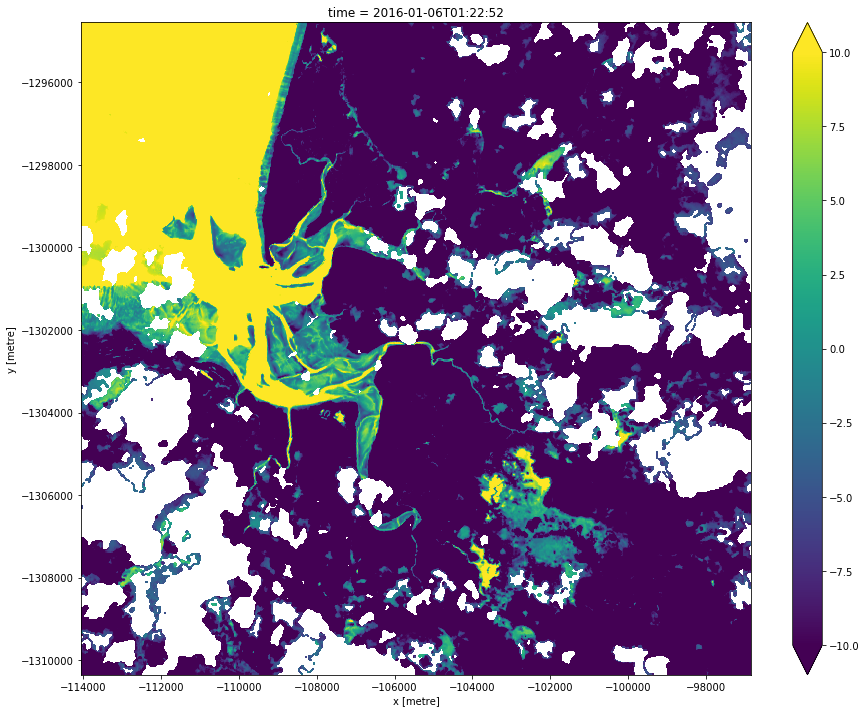

In [87]:
lst_fisher.isel(time=0).plot(cmap='viridis', figsize =(15,12),vmin=-10,)

In [75]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-400))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

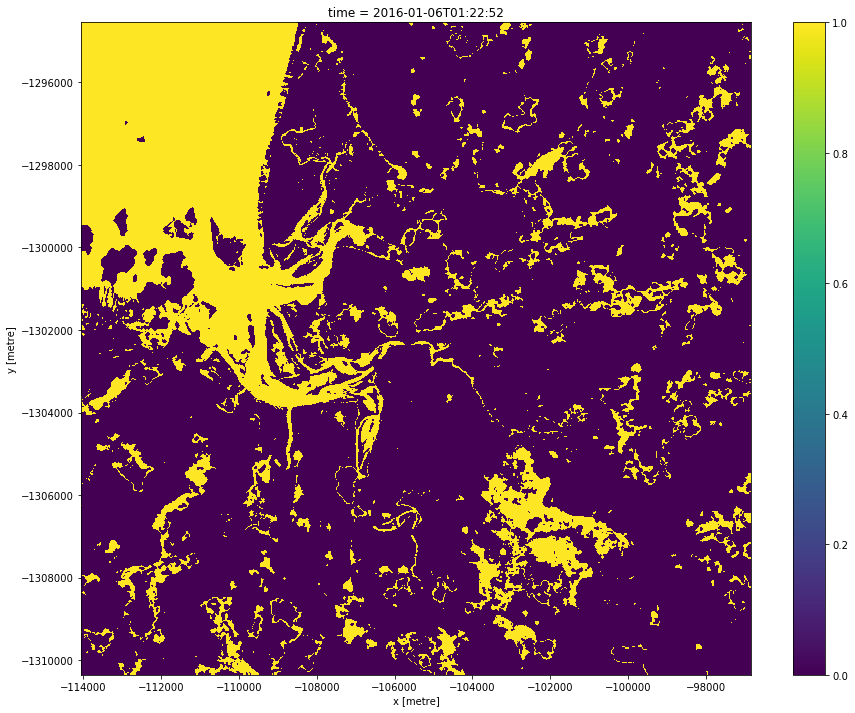

In [88]:
inundated_veg.isel(time=0).plot(cmap='viridis', figsize =(15,12))

In [77]:
wet_frequency = inundated_veg.sum(dim='time')

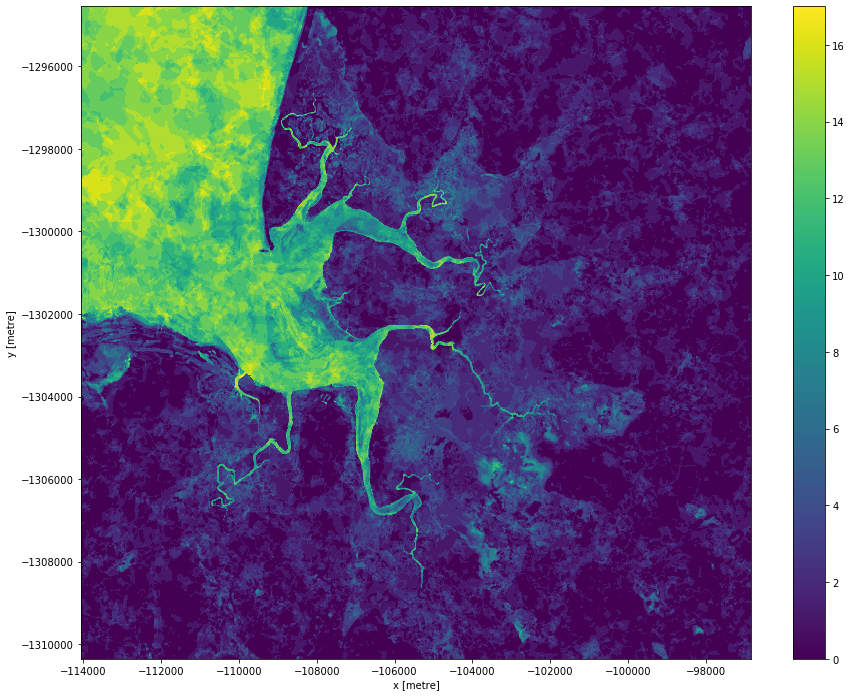

In [89]:
wet_frequency.plot(cmap='viridis', figsize =(15
                                             ,12))

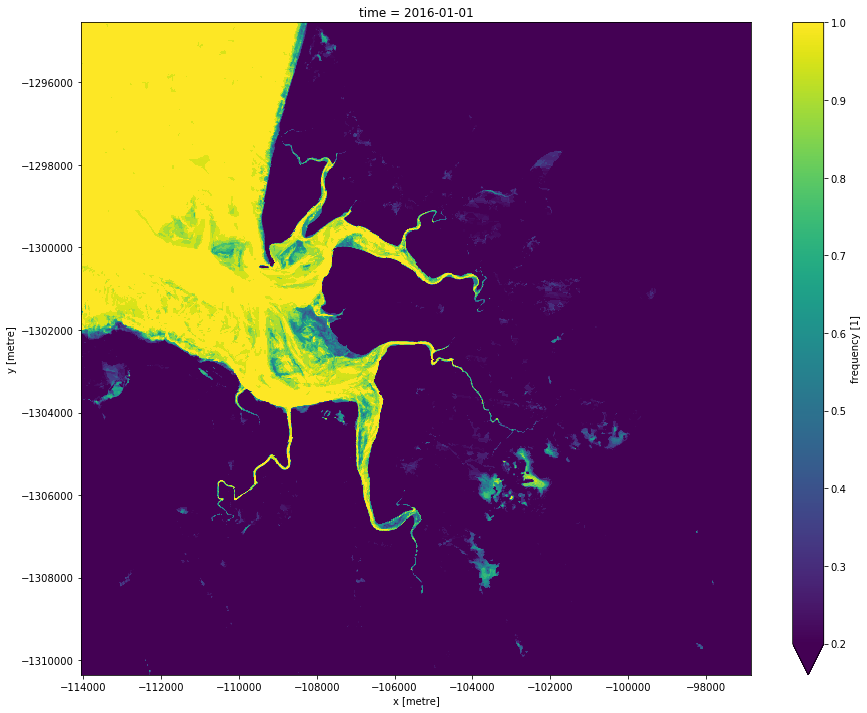

In [90]:
wofs_filtered_summary.frequency.plot(cmap='viridis',figsize =(15,12),vmin=0.2,)

In [80]:
precent_threhold = total_obs*0.2
precent_threhold

4.6000000000000005

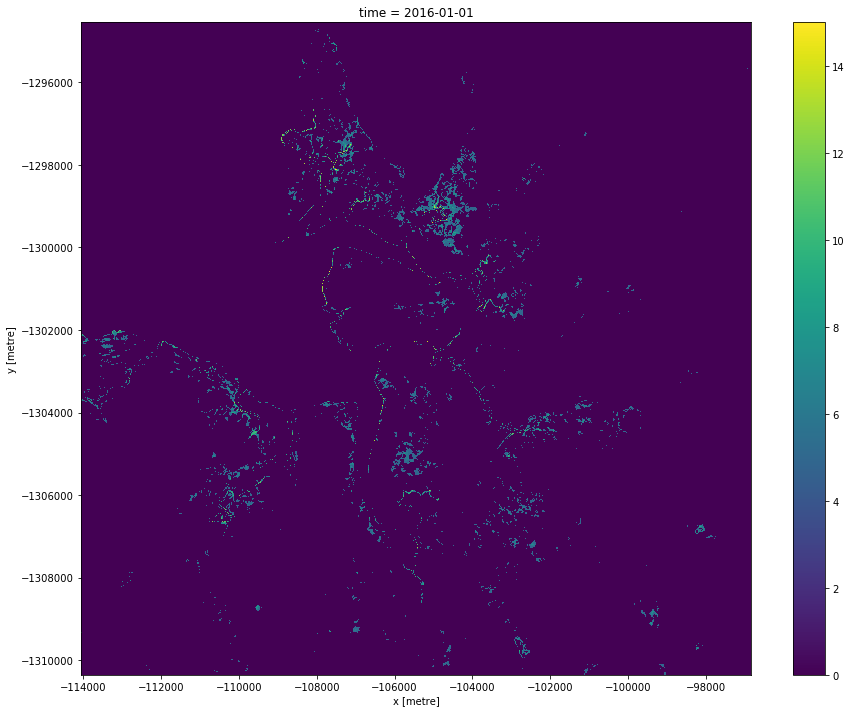

In [92]:
persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)
persistant_wet = persistant_wet.where(wofs_filtered_summary.frequency<0.2,0)
persistant_wet.plot(figsize =(15,12))

In [82]:
# Masked_lst8_data

In [83]:
# Data_out = Masked_lst8_data.drop(['coastal_aerosol','nir','swir1','swir2'])
# Data_out['inundated_veg'] = inundated_veg.astype('float64')
# # Data_out

In [84]:
# Data_out_once = Data_out.isel(time=0)
# Data_out_once['persistant_wet']=persistant_wet.astype('float64')
# Data_out_once['WOfS_frequency']=wofs_filtered_summary.frequency.isel(time=0).astype('float64')
# Data_out_once

In [85]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Tiletest_-2_-14_2018.tif',Data_out_once)